# **Stantec - Data Science interview**


1.  Determine the quality of the datasets, including if you think there are any false indications of a spill, and provide commentary on the processes used to assess the data and mitigate any data issues.
2.  Based on your review of the data, would you have any questions that you would ask the client in order to understand the data more fully.
3.  Assess if there is any link between the rainfall and pumping station data with spills from the CSO.
4.  Investigate any other potential relationships between the datasets.
Give any next steps that you might have as a result of your findings.

# Data normalisation / Cleaning / New features

In [ ]:
import pandas as pd

# I've stored the files individually on my GitHub for faster loading
r0 = pd.read_csv("https://raw.githubusercontent.com/julien-blanchard/stantec/main/RG_A.csv")
a0 = pd.read_csv("https://raw.githubusercontent.com/julien-blanchard/stantec/main/CSO_A.csv")
a1 = pd.read_csv("https://raw.githubusercontent.com/julien-blanchard/stantec/main/SPS_A1.csv")
a2 = pd.read_csv("https://raw.githubusercontent.com/julien-blanchard/stantec/main/SPS_A2.csv")

In [ ]:
# just a simple function that uses f-strings and a bit of formatting to show some info about the files
def getStats(data):
    print(
        f"""
            {'*' * 25}\n
            File name: {data.iloc[0][0]}\n
            Number of rows: {data.shape[0]}\n
            Number of columns: {data.shape[1]}\n
            Ratio: {round(data.shape[1] / data.shape[0], 3)}\n
            First timestamp: {data.iloc[0][1]}\n
            Second timestamp: {data.iloc[-1][1]}\n
            Null values: {data.isna().sum().sum()}
        """
    )

for file in [a0,a1,a2]:
    getStats(file)


            *************************

            File name: SPS_A

            Number of rows: 525600

            Number of columns: 3

            Ratio: 0.0

            First timestamp: 2017-04-01 00:00:00

            Second timestamp: 2018-04-01 00:00:00

            Null values: 0
        

            *************************

            File name: SPS_A1

            Number of rows: 1466

            Number of columns: 4

            Ratio: 0.003

            First timestamp: 2017-04-20 14:54:54

            Second timestamp: 2018-03-31 23:47:49

            Null values: 0
        

            *************************

            File name: SPS_A2

            Number of rows: 1464

            Number of columns: 4

            Ratio: 0.003

            First timestamp: 2017-04-20 14:55:34

            Second timestamp: 2018-03-31 23:59:32

            Null values: 0
        


In [ ]:
# right, this is where we're going to join our dataframe

def getPrimaryKey(data):
    # both SPS files have SPS1 or SPS2 as a first column. We'll be using this to rename the "exploded" columns
    name = data["Site"][0]
    dframe = data.filter(["Timestamp","StateDesc"])
    # creating dummies, so roughly, like a pivot in Excel
    dframe = pd.get_dummies(
        dframe,
        prefix=name,
        columns=["StateDesc"]
        )
    # here we're only keeping the date and hour. So, getting rid of the minutes and second
    dframe["Timestamp"] = pd.to_datetime(dframe["Timestamp"]).dt.strftime('%Y-%m-%d %H')
    cols = [c for c in dframe.columns]
    # and now we're doing a group by, by sum
    dframe = dframe.groupby(
        cols[0], as_index=False
    ).agg(
        {
            cols[1]: "sum",
            cols[2]: "sum"
        }
    )
    return dframe

# pretty much the same logic, but for the CSO level
def getNormalized(data,col1,col2):
    dframe = (
        data
        .assign(DateTime = lambda x: pd.to_datetime(x[col1]).dt.strftime('%Y-%m-%d %H'))
        .groupby(
            "DateTime",
            as_index=False
        )
        .agg(
            {
                col2: "mean"
            }
        )
        .filter(["DateTime",col2])
    )
    return dframe

# we now have primary keys that we can LEFT JOIN dataframes on
def getJoins(left,right,left_on,right_on):
    dframe = pd.merge(
        left,
        right,
        how="left",
        left_on=left_on,
        right_on=right_on
    )
    return dframe.drop(columns=[right_on])

In [ ]:
# applying the above functions to our files
df_r = getNormalized(r0,"time","RG_A")
df_r.rename(columns={"DateTime":"Timestamp"}, inplace=True)
df_a = getNormalized(a0,"DateTime","Level")
df_a1 = getPrimaryKey(a1)
df_a2 = getPrimaryKey(a2)

# by the way, the "exploded" SPS dataframes look like this
df_a1.head()

,Timestamp,SPS_A1_RUNNING,SPS_A1_STOPPED
0,2017-04-20 14,1,1
1,2017-04-25 20,2,2
2,2017-05-14 01,1,1
3,2017-05-14 04,1,1
4,2017-05-14 05,2,2


In [ ]:
# Pandas doesn't support JOINing multiple dataframes. So, 1 by 1
df_join_one = getJoins(df_a,df_a1,"DateTime","Timestamp")
df_join_two = getJoins(df_join_one,df_a2,"DateTime","Timestamp")
df_joined = getJoins(df_join_two,df_r,"DateTime","Timestamp")
df_joined.fillna(0, inplace=True)

# looks like this now
df_joined.head()

,DateTime,Level,SPS_A1_RUNNING,SPS_A1_STOPPED,SPS_A2_RUNNING,SPS_A2_STOPPED,RG_A
0,2017-04-01 00,7.631663,0.0,0.0,0.0,0.0,0.0
1,2017-04-01 01,3.816442,0.0,0.0,0.0,0.0,0.0
2,2017-04-01 02,3.949938,0.0,0.0,0.0,0.0,0.0
3,2017-04-01 03,5.215709,0.0,0.0,0.0,0.0,0.0
4,2017-04-01 04,5.091981,0.0,0.0,0.0,0.0,0.0


In [ ]:
# this is pretty straightforward: we're progressively adding in new features
def addFeatures(data):
    dframe = data.copy()
    dframe["Date"] = pd.to_datetime(dframe.DateTime).dt.strftime("%Y-%m-%d")
    dframe["Delta"] = dframe["Level"] - dframe["Level"].shift(1)
    dframe["Hour"] = dframe["DateTime"].apply(lambda x: str(x).split(" ")[1])
    dframe["DateTime"] = pd.to_datetime(dframe.DateTime)
    dframe["Month"] = dframe.DateTime.dt.month_name()
    dframe["Week"] = dframe.DateTime.dt.isocalendar().week
    dframe["Day"] = dframe.DateTime.dt.day_name()
    return dframe

df = addFeatures(df_joined)

# we only have a tiny time window with data across all the files
start_day = pd.to_datetime("2017-04-20")
end_day = pd.to_datetime("2018-03-31")
df = df[df["DateTime"].between(start_day, end_day)]

df.head(10)

,DateTime,Level,SPS_A1_RUNNING,SPS_A1_STOPPED,SPS_A2_RUNNING,SPS_A2_STOPPED,RG_A,Date,Delta,Hour,Month,Week,Day
456,2017-04-20 00:00:00,6.750914,0.0,0.0,0.0,0.0,0.0,2017-04-20,-7.364264,00,April,16,Thursday
457,2017-04-20 01:00:00,5.750915,0.0,0.0,0.0,0.0,0.0,2017-04-20,-1.000000,01,April,16,Thursday
458,2017-04-20 02:00:00,4.059828,0.0,0.0,0.0,0.0,0.0,2017-04-20,-1.691086,02,April,16,Thursday
459,2017-04-20 03:00:00,7.180707,0.0,0.0,0.0,0.0,0.0,2017-04-20,3.120878,03,April,16,Thursday
460,2017-04-20 04:00:00,4.679690,0.0,0.0,0.0,0.0,0.0,2017-04-20,-2.501017,04,April,16,Thursday
461,2017-04-20 05:00:00,4.142856,0.0,0.0,0.0,0.0,0.0,2017-04-20,-0.536833,05,April,16,Thursday
462,2017-04-20 06:00:00,8.203905,0.0,0.0,0.0,0.0,0.0,2017-04-20,4.061049,06,April,16,Thursday
463,2017-04-20 07:00:00,8.067153,0.0,0.0,0.0,0.0,0.0,2017-04-20,-0.136752,07,April,16,Thursday
464,2017-04-20 08:00:00,11.733412,0.0,0.0,0.0,0.0,0.0,2017-04-20,3.666259,08,April,16,Thursday
465,2017-04-20 09:00:00,16.190473,0.0,0.0,0.0,0.0,0.0,2017-04-20,4.457060,09,April,16,Thursday


In [ ]:
# that's mor data quality stuff. Wanted to make sure that the SPS pumps worked on a sequential RUNNING => STOPPED => RUNNING => STOPPED system
from collections import Counter

def checkErrors(data):
    struct = []
    for i in range(0,len(data)-1):
        if data["StateDesc"][i] == data["StateDesc"][i+1]:
            struct.append("yes")
        else:
            struct.append("no")
    return struct

errors = checkErrors(a2)
Counter(errors)

Counter({'no': 1463})

In [ ]:
df.to_csv("full_data.csv",index=False)

# Plotting functions (hidden)

In [ ]:
# we're going old school: Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

### aesthetics ###

# global template
sns.set_style("whitegrid")

# font, size, stuff like that
rc = {
    "figure.figsize": (18,7),
    "axes.edgecolor": "white",
    "font.family": "monospace",
    "font.size": 13
     }
plt.rcParams.update(rc)

# manually setting up a color palette for line charts, based on https://www.learnui.design/tools/data-color-picker.html#single
blue = ["#004c6d","#30729a","#569bc9","#7bc6fa"]

def getHexColors(palette):
    new_cmap = ListedColormap(palette, name="new_cmap")
    return new_cmap.reversed()

blue_palette = getHexColors(blue)

In [ ]:
# really, all these chart functions are longer than they should. 80% of the code there is about aesthetics
def getBarCharts(x1,y1,x2,y2,title1,title2):
    fig = plt.figure()
    plt.subplot(121)
    left = sns.barplot(x=x1, y=y1, orient="h", palette="Blues_r")
    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.xlabel("")
    plt.ylabel("")
    left.set_title(title1)
    plt.subplot(122)
    right = sns.barplot(x=x2, y=y2, orient="h", palette="Blues_r")
    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.xlabel("")
    plt.ylabel("")
    right.set_title(title2)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
    plt.show()

# subtle change here: using pandas's .plot() method makes it easier to plot time series and stacked values
def getStackedBars(data,x,title):
    data.plot(
        kind="bar",
        x=x,
        stacked=True,
        legend="upper right",
        cmap=blue_palette,
        title=title,
        );

# moving over to seaborn, but the logic is the same: a figure() object, a plot, and loads of aesthetics
def getHistPlots(x1,x2,title1,title2):
    fig = plt.figure()
    plt.subplot(121)
    left = sns.histplot(x1, kde=True, bins=10)
    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.xlabel("")
    plt.ylabel('')
    left.set_title(title1)
    plt.subplot(122)
    right = sns.histplot(x2, kde=True, bins=10)
    sns.despine(left=True, right=True, top=True, bottom=True)
    plt.xlabel("")
    plt.ylabel("")
    right.set_title(title2)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
    plt.show()

def getAreaPlot(data,x,stacked,title):
    data.plot(
        x=x,
        kind="area",
        stacked=stacked,
        cmap=blue_palette,
        title=title
    );

# here, we had a double horizontal line that shows 2 standard deviations either below or above the mean.
def getLinePlot(data,x,y,title):
    m = stats.median(data[y]) * 2
    s = stats.stdev(data[y]) * 2
    med = [m for _ in range(0,len(data[y]))]
    up_stdev = [(m+s) for _ in range(0,len(data[y]))]
    low_stdev = [(m-s) for _ in range(0,len(data[y]))]
    data.plot(
        x=x,
        title=title
    )
    plt.plot(
        data[x],
        up_stdev,
        label="Upper standard deviation",
        color="gray",
        linewidth=4,
        linestyle="-.",
        alpha=0.5
        )
    plt.plot(
        data[x],
        low_stdev,
        label="Lower standard deviation",
        color="gray",
        linewidth=4,
        linestyle="-.",
        alpha=0.5
        )
    plt.legend(loc="upper right")

# Data exploration

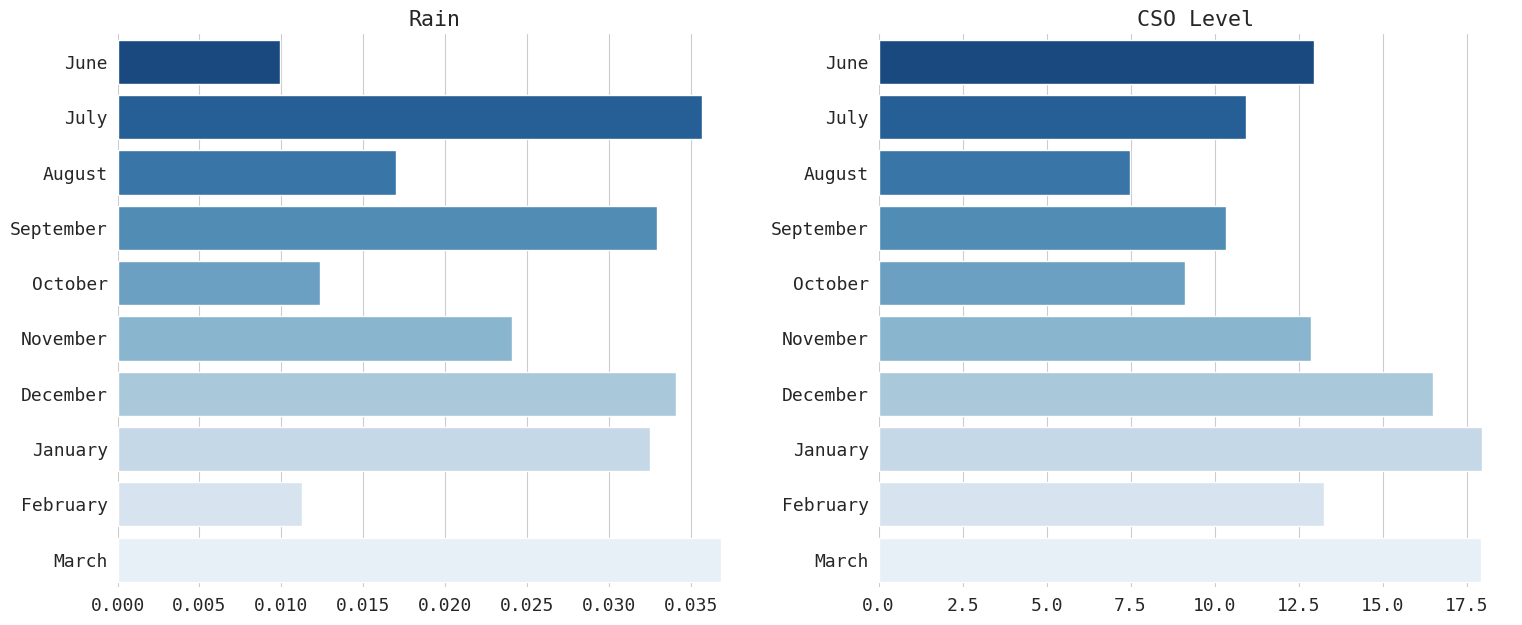

In [ ]:
# returns a SQL-like GROUP BY. I highly recommend setting as_index as False as it otherwise sets column names on multilevels
def getGroupBy(data,col,agg):
    dframe = data.groupby(col, as_index=False, sort=False).agg(agg)
    return dframe

plot_left = getGroupBy(df,"Month",{"RG_A":"mean"})[2:]
plot_right = getGroupBy(df,"Month",{"Level":"mean"})[2:]

getBarCharts(
    plot_left["RG_A"],
    plot_left["Month"],
    plot_right["Level"],
    plot_right["Month"],
    "Rain",
    "CSO Level"
    )

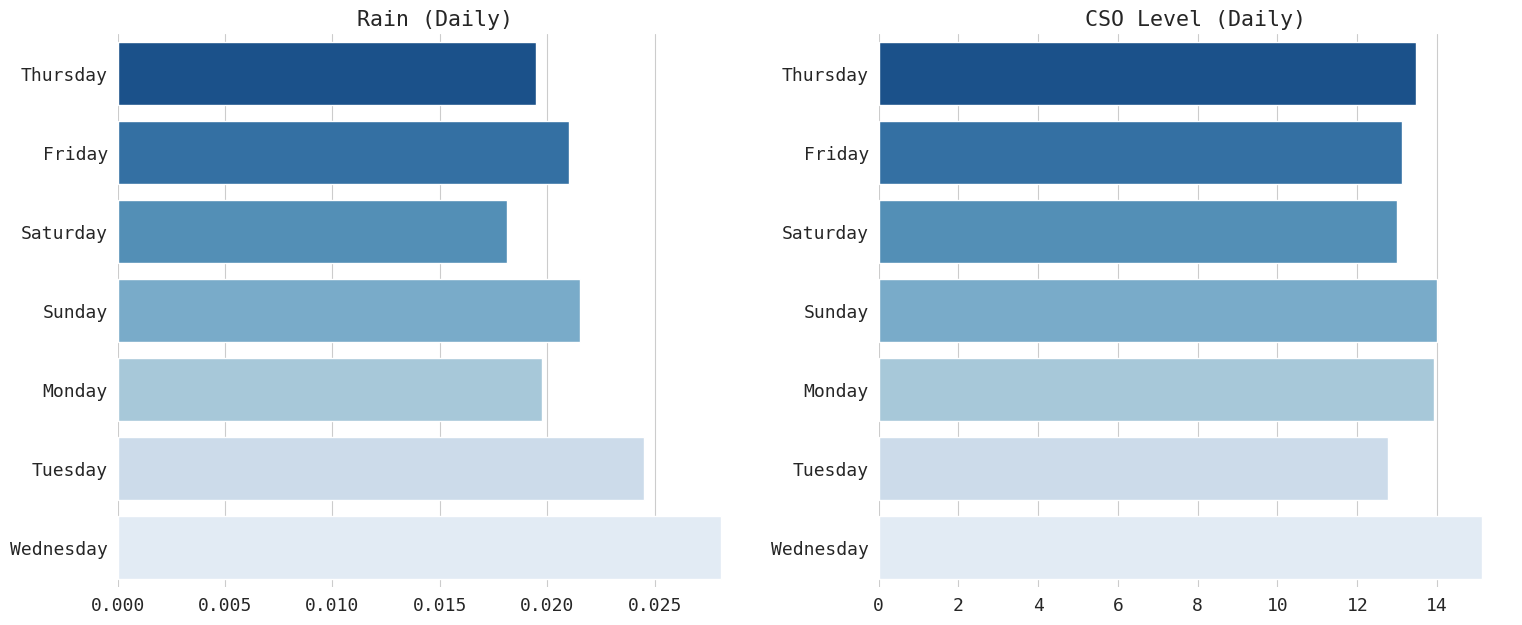

In [ ]:
# same as above, just different metrics
plot_left = getGroupBy(df,"Day",{"RG_A":"mean"})
plot_right = getGroupBy(df,"Day",{"Level":"mean"})

getBarCharts(
    plot_left["RG_A"],
    plot_left["Day"],
    plot_right["Level"],
    plot_right["Day"],
    "Rain (Daily)",
    "CSO Level (Daily)"
    )

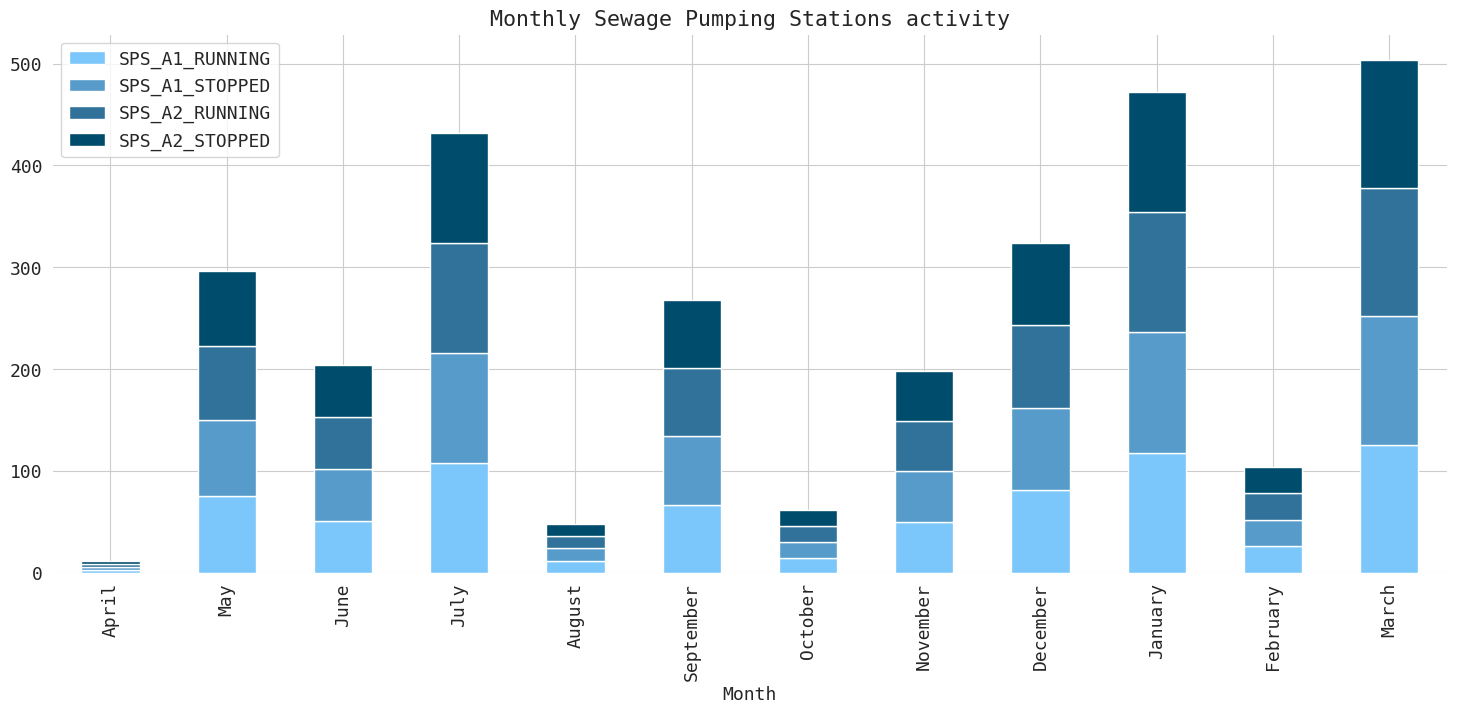

In [ ]:
# again, same approach
sps = ["SPS_A1_RUNNING","SPS_A1_STOPPED", "SPS_A2_RUNNING", "SPS_A2_STOPPED"]
plot = getGroupBy(df,"Month",{"SPS_A1_RUNNING":"sum","SPS_A1_STOPPED":"sum","SPS_A2_RUNNING":"sum","SPS_A2_STOPPED":"sum"})
getStackedBars(plot,"Month","Monthly Sewage Pumping Stations activity")

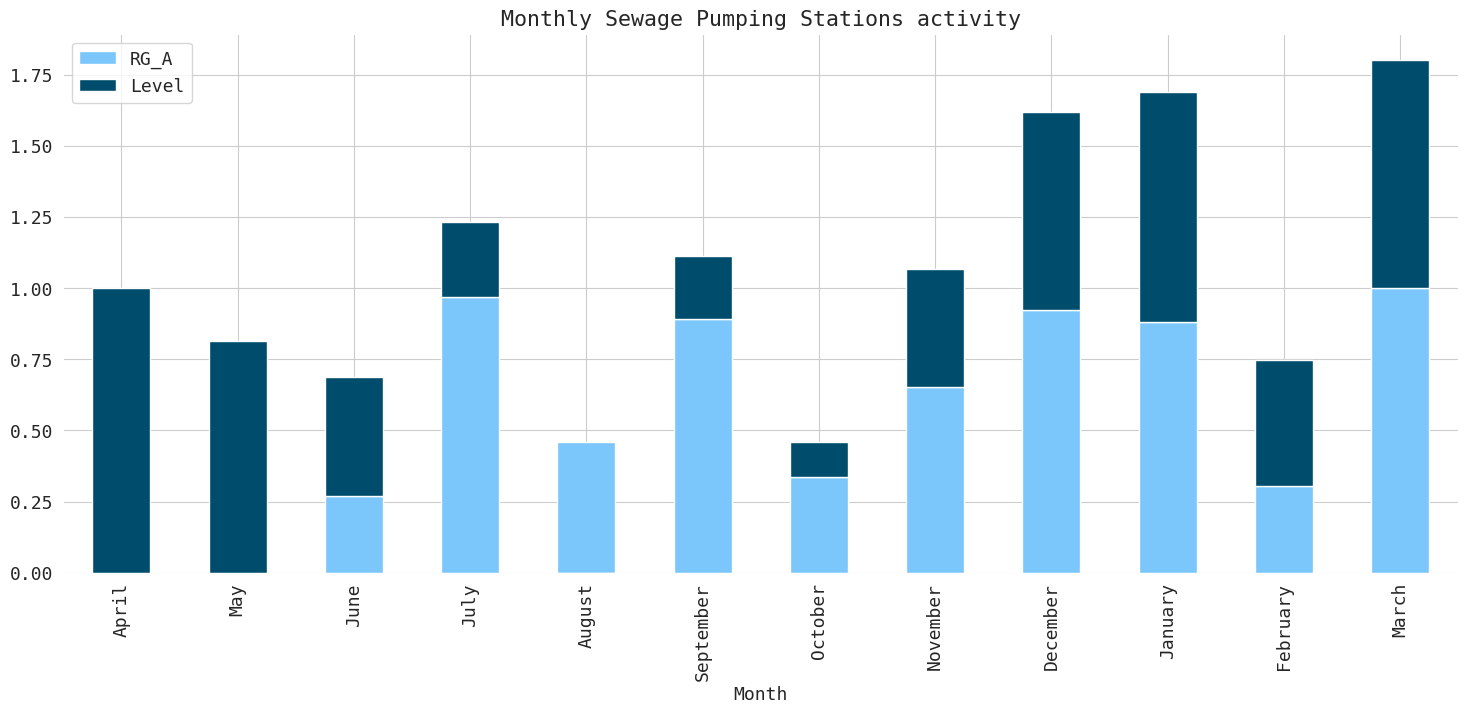

In [ ]:
# the values of rain and CSO levels are on a different scale. Rescaling them first on a range of (0,1) works best for visualisation
from sklearn.preprocessing import MinMaxScaler

def getNormalized(data,idx,cols):
    dframe = data.filter([idx])
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[cols])
    scaled_df = pd.DataFrame(scaled, columns=cols)
    dframe[cols] = scaled_df[cols]
    return dframe

plot_data = getGroupBy(df,"Month",{"RG_A": "mean","Level":"mean"})
plot = getNormalized(plot_data,"Month",["RG_A","Level"])
getStackedBars(plot,"Month","Monthly Sewage Pumping Stations activity")

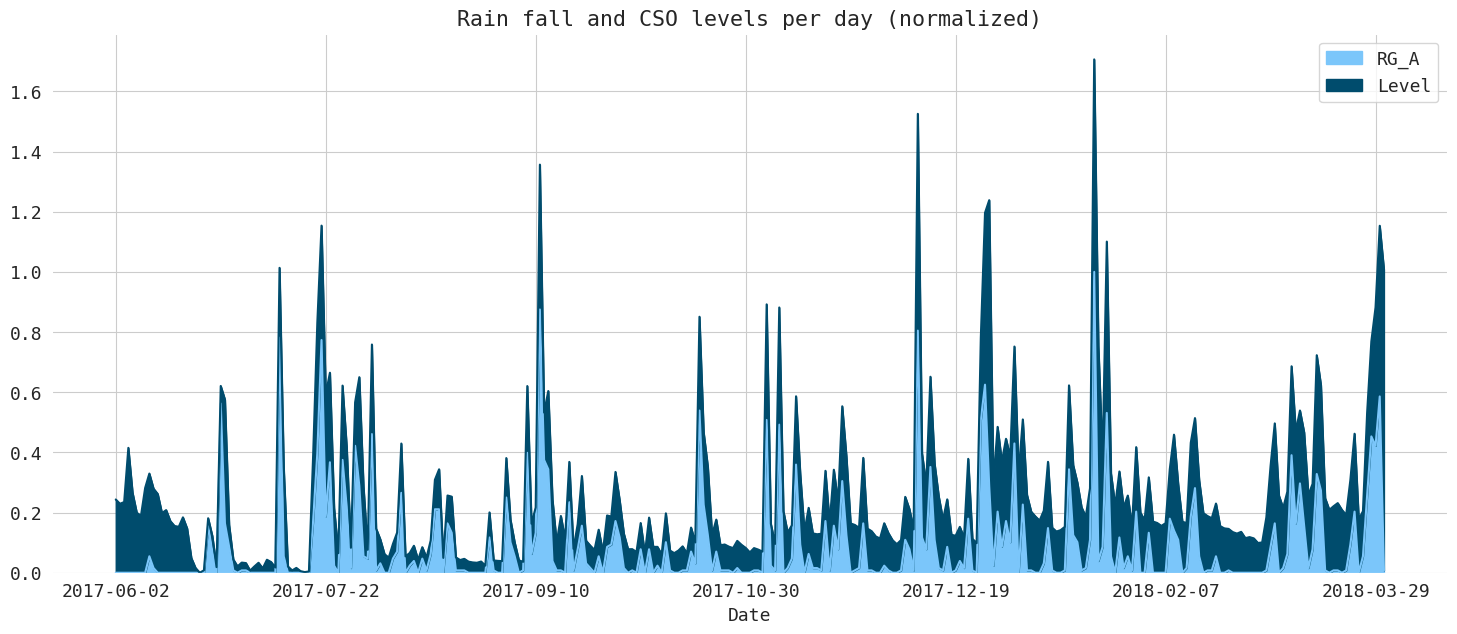

In [ ]:
# same, but by day instead of month
rain = df.query("Date > '2017-06-01'")
plot_data = getGroupBy(rain,"Date",{"RG_A": "sum","Level":"mean"})
plot = getNormalized(plot_data,"Date",["RG_A","Level"])
getAreaPlot(plot,"Date",True,"Rain fall and CSO levels per day (normalized)")

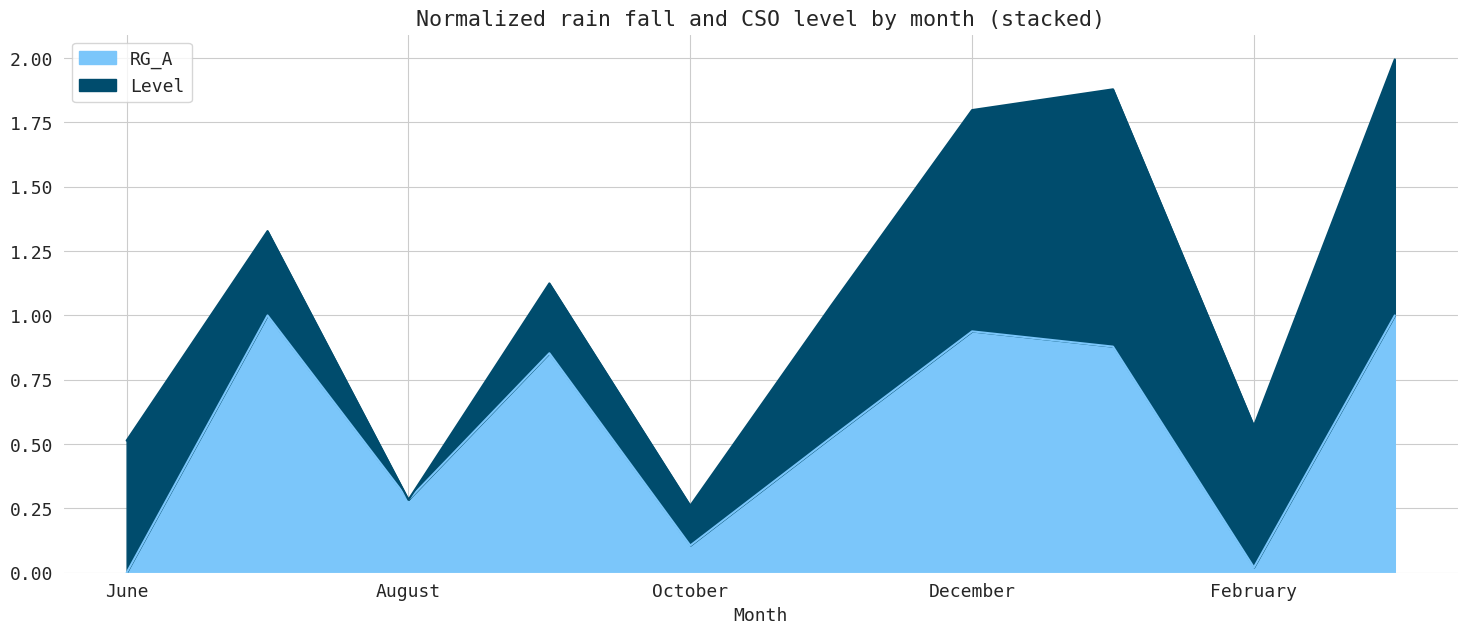

In [ ]:
# similar as the first plot, but an area chart will reveal potential correlations better
plot_data = getGroupBy(rain,"Month",{"RG_A": "sum","Level":"mean"})
plot = getNormalized(plot_data,"Month",["RG_A","Level"])
getAreaPlot(plot,"Month",True,"Normalized rain fall and CSO level by month (stacked)")

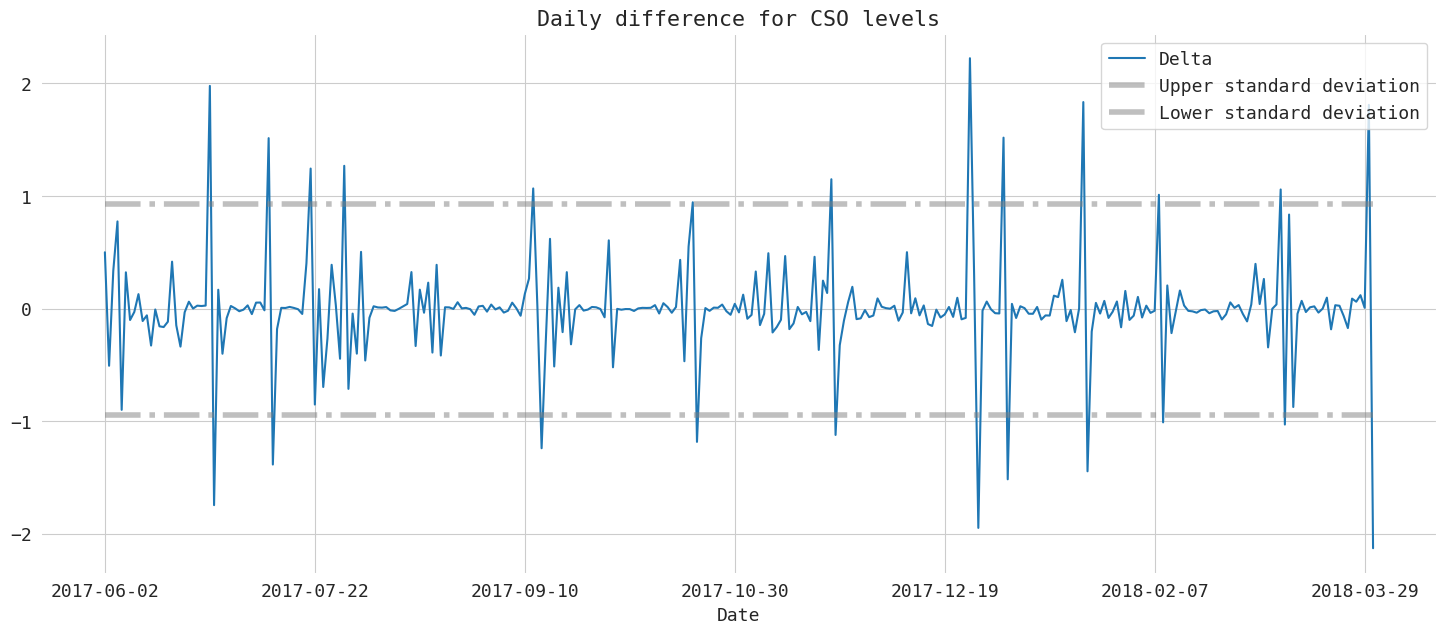

In [ ]:
# here, we plot the daily difference (hence why the mean equals 0), and add 2 standard deviations above the mean
import statistics as stats

plot_data = getGroupBy(rain,"Date",{"Delta":"mean"})
getLinePlot(plot_data,"Date","Delta","Daily difference for CSO levels")

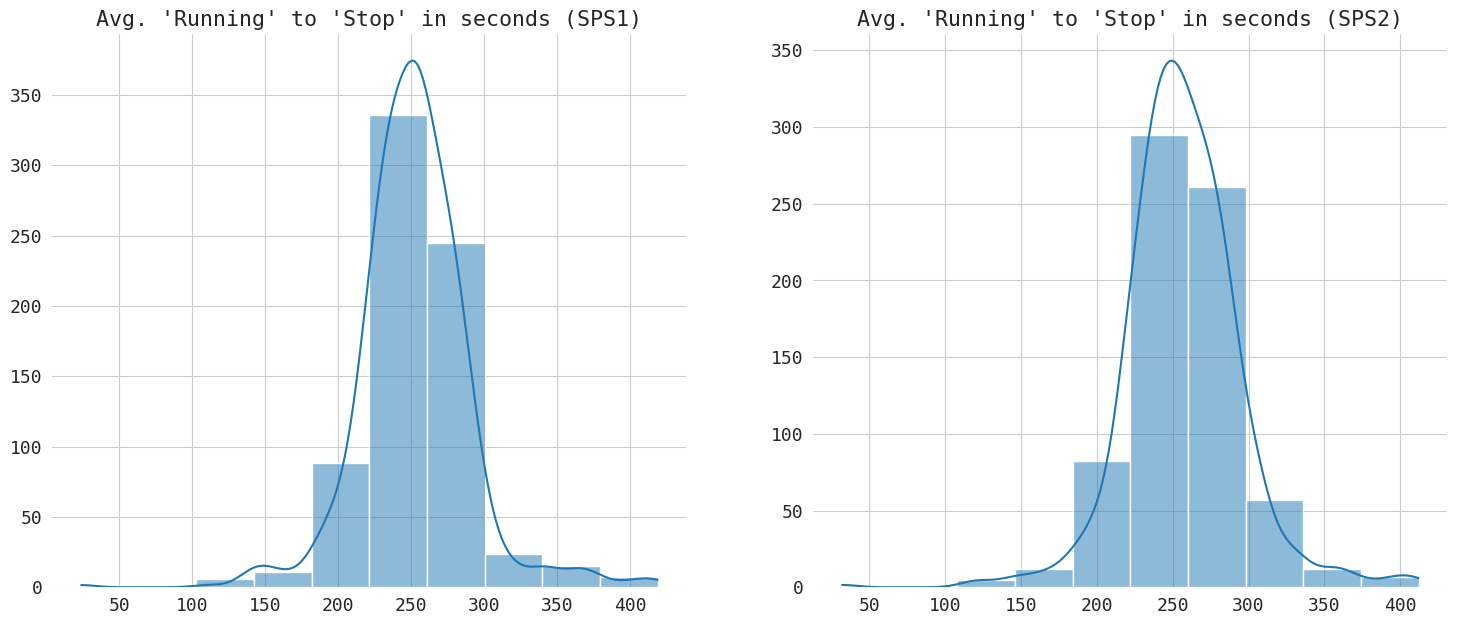

In [ ]:
# now that requires slightly more explanations:
import datetime

def getTimeDelta(data,col1,col2):
    struct = []
    # we loop through the total length of the dataframe, in C / C++ like style: for (unsigned int i = 0; i < dataframe.size(); i++) {dosomething[i]}
    for i in range(0,len(data)-1):
        # if the value at index i is "RUNNING", we calculate the time delta between value[i] and value[i+1] (in other word, the delta between RUNNING and STOPPED)
        if data[col2][i] == "RUNNING":
            struct.append(
                (pd.to_datetime(data[col1][i+1]) - pd.to_datetime(data[col1][i])).total_seconds()
            )
    # we stored these time deltas in an array called struct
    return struct

plot_left = getTimeDelta(a1,"Timestamp","StateDesc")
plot_right = getTimeDelta(a2,"Timestamp","StateDesc")
getHistPlots(plot_left,plot_right,"Avg. 'Running' to 'Stop' in seconds (SPS1)","Avg. 'Running' to 'Stop' in seconds (SPS2)")

# Data modelling / stats

In [ ]:
from sklearn.preprocessing import LabelEncoder

feats = df.filter(["SPS_A1_RUNNING","SPS_A1_STOPPED","SPS_A2_RUNNING","SPS_A2_STOPPED","RG_A","Delta"])

le = LabelEncoder()
feats["Day"] = le.fit_transform(df["Day"])
feats["Month"] = le.fit_transform(df["Month"])
feats["Level"] = df["Level"]
feats.head()

,SPS_A1_RUNNING,SPS_A1_STOPPED,SPS_A2_RUNNING,SPS_A2_STOPPED,RG_A,Delta,Day,Month,Level
456,0.0,0.0,0.0,0.0,0.0,-7.364264,4,0,6.750914
457,0.0,0.0,0.0,0.0,0.0,-1.000000,4,0,5.750915
458,0.0,0.0,0.0,0.0,0.0,-1.691086,4,0,4.059828
459,0.0,0.0,0.0,0.0,0.0,3.120878,4,0,7.180707
460,0.0,0.0,0.0,0.0,0.0,-2.501017,4,0,4.679690


In [ ]:
import numpy as np
from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def getTopFeatures(data,target,n_features):

    # pre-work
    nu_cols = len(data.columns) - 1
    cols = data.drop(columns=[target]).columns
    scaled = scaler.fit_transform(data)

    # assuming the target variable is the last column
    X = scaled[:,0:nu_cols]
    Y = scaled[:,nu_cols]

    # feature extraction
    model = SVR(kernel="linear")
    rfe = RFE(
        model,
        n_features_to_select=n_features,
        step=1
        )
    fit = rfe.fit(X, Y)

    # results
    struct = {
        "Feature": [data.columns[n] for n in range(0,nu_cols)],
        "Important": [fit.support_[n] for n in range(0,nu_cols)],
        "Ranking": [fit.ranking_[n] for n in range(0,nu_cols)]
    }
    results = pd.DataFrame(struct).sort_values("Ranking", ascending=True)
    return results

getTopFeatures(feats,"Level",3)

,Feature,Important,Ranking
0,SPS_A1_RUNNING,True,1
4,RG_A,True,1
5,Delta,True,1
2,SPS_A2_RUNNING,False,2
3,SPS_A2_STOPPED,False,3
1,SPS_A1_STOPPED,False,4
7,Month,False,5
6,Day,False,6


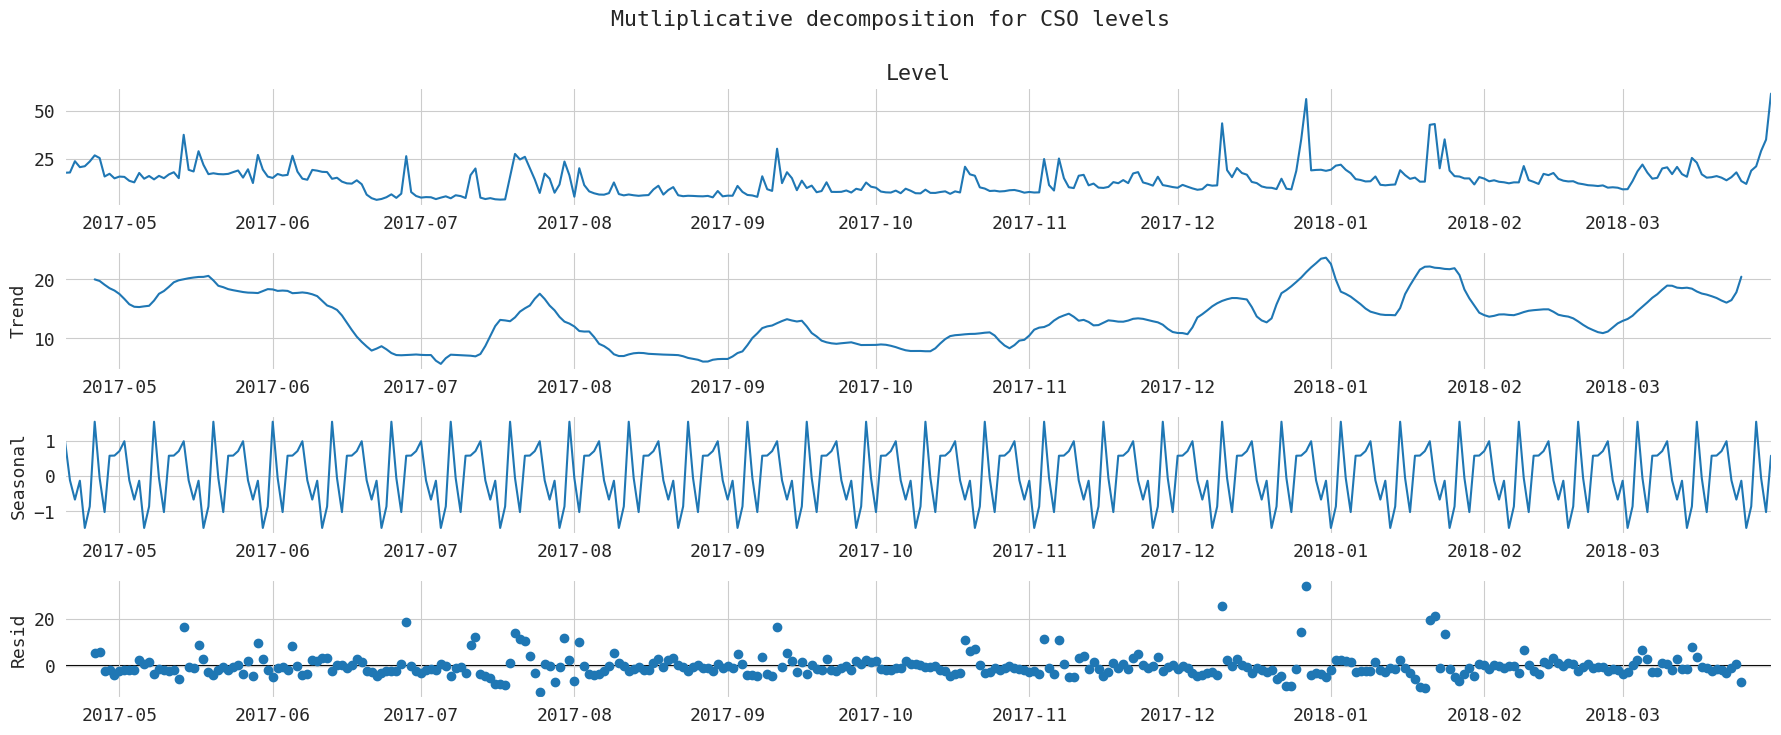

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def getDecompositionPlot(data,freq,title):
    results = seasonal_decompose(
        x=data,
        period=freq,
        model="additive"
        )

    plt.rc("figure")
    results.plot().suptitle(title, y=1.05)
    plt.show()

seas_dec = getGroupBy(df,"Date",{"Level": "mean"})
seas_dec = seas_dec.set_index(pd.DatetimeIndex(seas_dec["Date"].values)).drop(columns=["Date"])
getDecompositionPlot(seas_dec["Level"],12,"Mutliplicative decomposition for CSO levels")

In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

def getProphetDF(data,serie1,serie2):
    result = (
        data
        .filter([serie1,serie2])
        .rename(columns={"Date":"ds","Level":"y"})
    )
    return result

df_ = getGroupBy(df,"Date",{"Level": "mean"})
df_prophet = getProphetDF(df_,"Date","Level")

In [ ]:
m = Prophet(
    daily_seasonality=True,
    interval_width=0.95,
    #n_changepoints=5
)
m.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr95jo07a/xsbdu3u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr95jo07a/b1fuv00_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37392', 'data', 'file=/tmp/tmpr95jo07a/xsbdu3u3.json', 'init=/tmp/tmpr95jo07a/b1fuv00_.json', 'output', 'file=/tmp/tmpr95jo07a/prophet_model4ucih1rz/prophet_model-20230725134120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=180, freq="D")
forecast = m.predict(future)
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
516,2018-09-18,27.330131,12.870119,39.778323,22.574834,32.262887,-0.846574,-0.846574,-0.846574,0.092427,0.092427,0.092427,-0.939001,-0.939001,-0.939001,0.0,0.0,0.0,26.483557
517,2018-09-19,27.378643,15.279752,42.678486,22.560636,32.395493,1.513424,1.513424,1.513424,0.092427,0.092427,0.092427,1.420997,1.420997,1.420997,0.0,0.0,0.0,28.892066
518,2018-09-20,27.427154,13.145847,41.147630,22.546439,32.478507,-0.252015,-0.252015,-0.252015,0.092427,0.092427,0.092427,-0.344442,-0.344442,-0.344442,0.0,0.0,0.0,27.175139
519,2018-09-21,27.475666,13.582397,40.283934,22.533636,32.556132,-0.602209,-0.602209,-0.602209,0.092427,0.092427,0.092427,-0.694636,-0.694636,-0.694636,0.0,0.0,0.0,26.873456
520,2018-09-22,27.524177,14.344936,42.236618,22.522227,32.633102,0.159795,0.159795,0.159795,0.092427,0.092427,0.092427,0.067368,0.067368,0.067368,0.0,0.0,0.0,27.683972
521,2018-09-23,27.572689,14.125076,42.204150,22.510818,32.709899,0.380519,0.380519,0.380519,0.092427,0.092427,0.092427,0.288092,0.288092,0.288092,0.0,0.0,0.0,27.953208
522,2018-09-24,27.621200,14.759139,41.391564,22.499327,32.797118,0.294050,0.294050,0.294050,0.092427,0.092427,0.092427,0.201623,0.201623,0.201623,0.0,0.0,0.0,27.915250
523,2018-09-25,27.669712,14.314558,40.560205,22.487755,32.893716,-0.846574,-0.846574,-0.846574,0.092427,0.092427,0.092427,-0.939001,-0.939001,-0.939001,0.0,0.0,0.0,26.823137
524,2018-09-26,27.718223,15.184854,43.392912,22.476742,32.990313,1.513424,1.513424,1.513424,0.092427,0.092427,0.092427,1.420997,1.420997,1.420997,0.0,0.0,0.0,29.231647
525,2018-09-27,27.766735,13.738793,41.126010,22.466083,33.086910,-0.252015,-0.252015,-0.252015,0.092427,0.092427,0.092427,-0.344442,-0.344442,-0.344442,0.0,0.0,0.0,27.514719


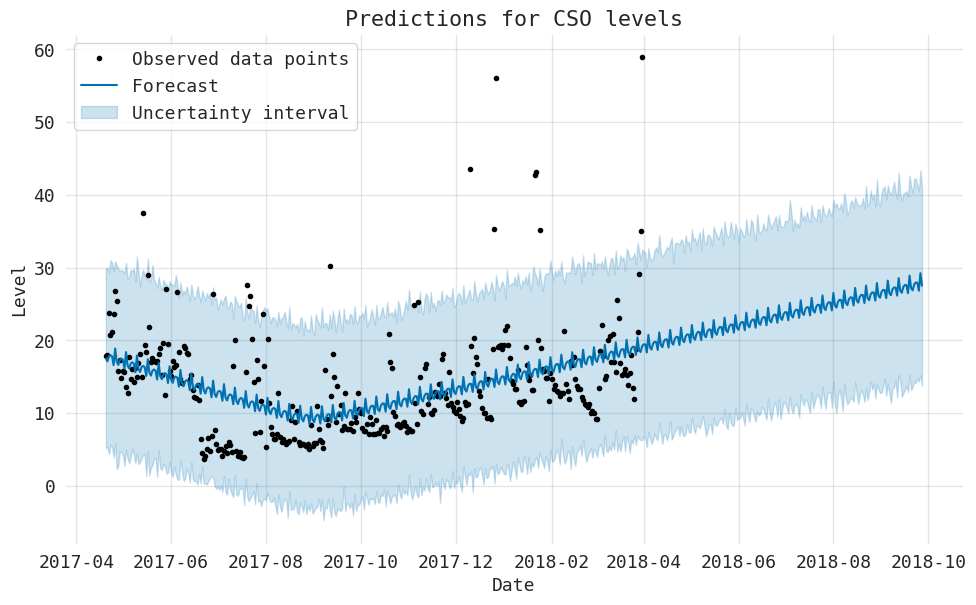

In [ ]:
from matplotlib import pyplot as plt

def getPredictionPlot(title):
    fig = m.plot(forecast, uncertainty=True)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Level")
    plt.legend(loc="upper left")

getPredictionPlot("Predictions for CSO levels")

# Missing data

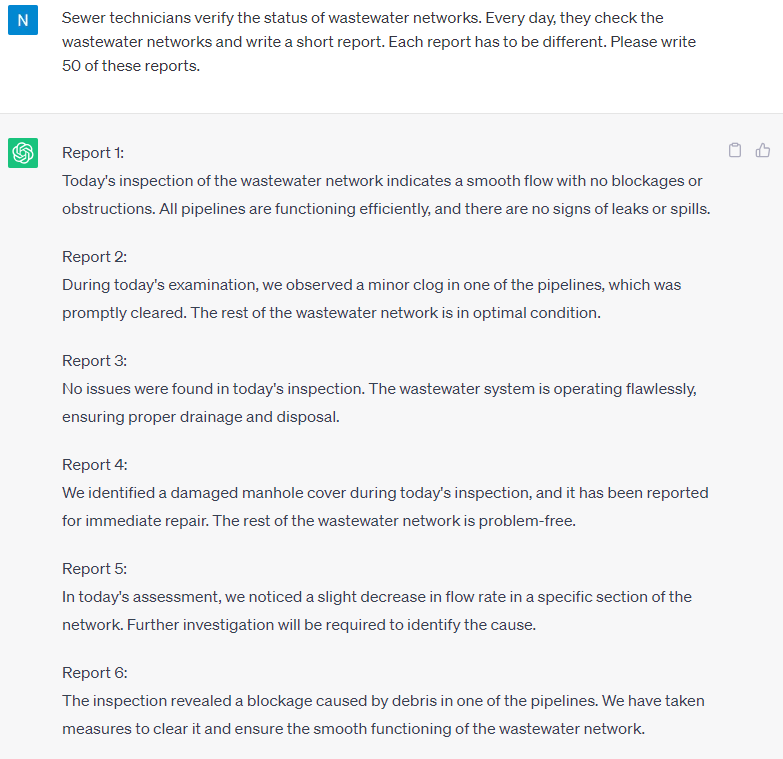

In [ ]:
!pip install keybert

In [ ]:
from urllib.request import urlopen
from keybert import KeyBERT

def getReports():
    struct = []
    file = "https://raw.githubusercontent.com/julien-blanchard/stantec/main/fake_sewer_reports.txt"
    fake_reports = urlopen(file).read().decode("utf-8")
    rows = fake_reports.split("\n")
    for idx in range(0,len(rows)):
        if rows[idx].startswith("Report"):
            struct.append(rows[idx+1].replace("\r",""))
    return struct

reports = getReports()
print(len(reports))

50


In [ ]:
def getGroupBy(data,col,agg):
    dframe = data.groupby(col, as_index=False, sort=False).agg(agg)
    return dframe

df_report = getGroupBy(df,"Date",{"Level":"mean","SPS_A1_RUNNING":"sum","SPS_A1_STOPPED":"sum","SPS_A2_RUNNING":"sum","SPS_A2_STOPPED":"sum","RG_A":"sum","Delta":"mean"}).tail(50)
df_report["Report"] = reports
df_report.head()

,Date,Level,SPS_A1_RUNNING,SPS_A1_STOPPED,SPS_A2_RUNNING,SPS_A2_STOPPED,RG_A,Delta,Report
296,2018-02-10,13.953718,0.0,0.0,0.0,0.0,0.7,0.205196,Today's inspection of the wastewater network i...
297,2018-02-11,13.038594,0.0,0.0,0.0,0.0,0.0,-0.218186,"During today's examination, we observed a mino..."
298,2018-02-12,11.961332,0.0,0.0,0.0,0.0,0.1,-0.029898,No issues were found in today's inspection. Th...
299,2018-02-13,17.198053,9.0,9.0,9.0,9.0,1.2,0.160104,We identified a damaged manhole cover during t...
300,2018-02-14,16.541884,2.0,1.0,1.0,1.0,1.8,0.027218,"In today's assessment, we noticed a slight dec..."


In [ ]:
def getKeywords(data,dimension):
    stpwds = ["wastewater","pipes","sewer","inspection","pipeline","pipelines"]
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(
        data,
        keyphrase_ngram_range=dimension,
        stop_words=stpwds,
        top_n=7
        )
    return keywords

reports_bigrams = getKeywords(" ".join(df_report["Report"]),(1,2))
reports_tokens = getKeywords(" ".join(df_report["Report"]),(1,1))

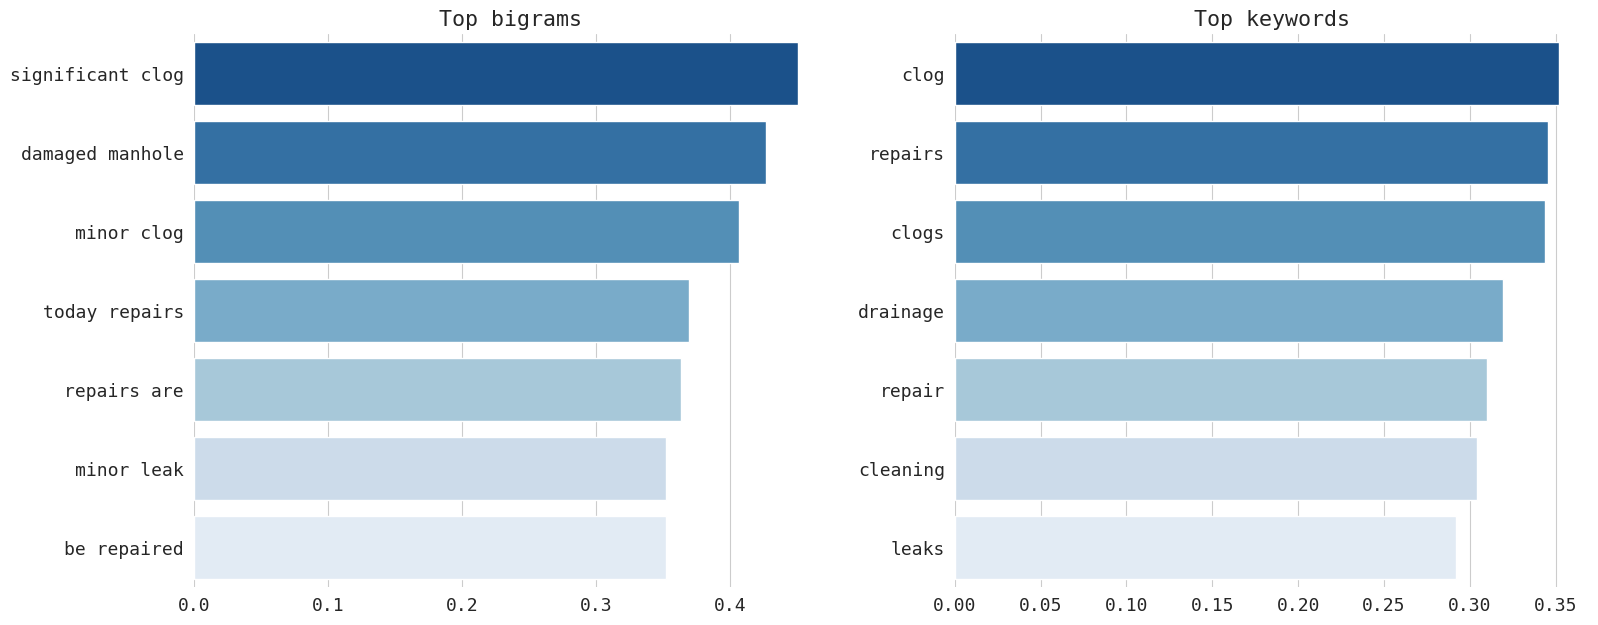

In [ ]:
getBarCharts(
    [b[1] for b in reports_bigrams],
    [b[0] for b in reports_bigrams],
    [b[1] for b in reports_tokens],
    [b[0] for b in reports_tokens],
    "Top bigrams",
    "Top keywords"
    )

# Not leading anywhere

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(feats)

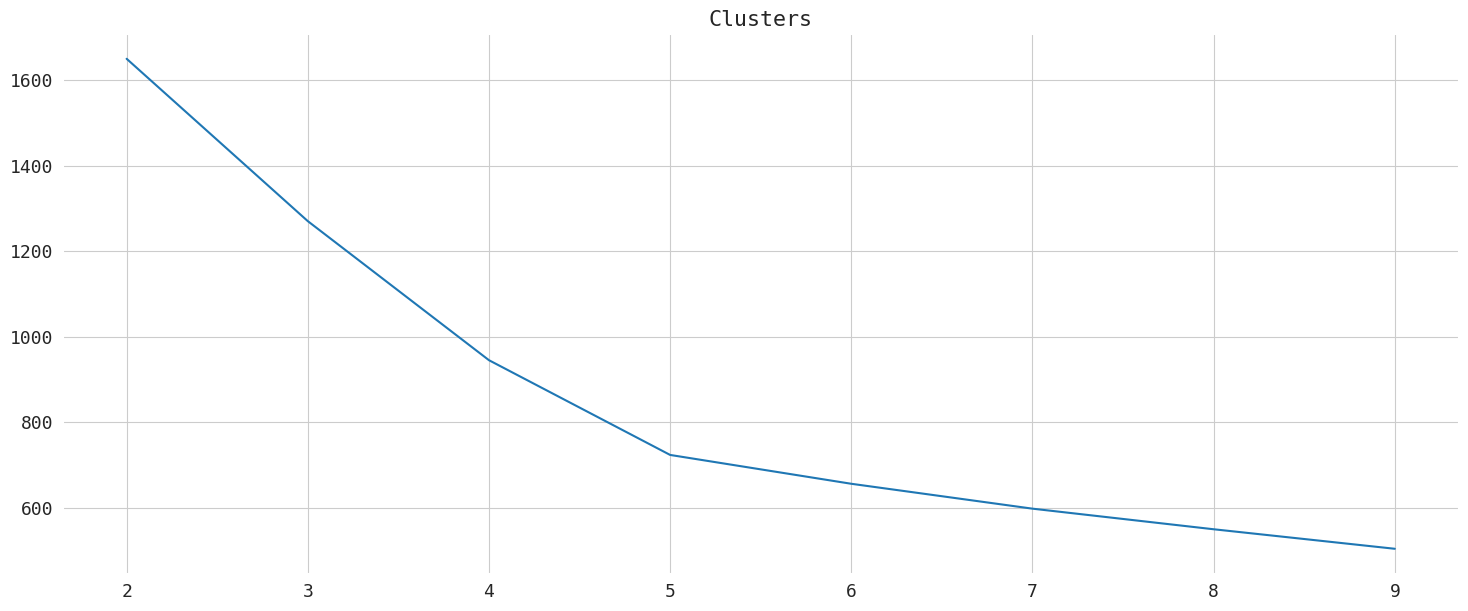

In [ ]:
inertias = []
sizes = range(2,10)

for k in sizes:
  k2 = KMeans(
      random_state=42,
      n_clusters=k
      )
  k2.fit(X_scaled)
  inertias.append(k2.inertia_)

# now, just a simple line chart
plt.figure()
pd.Series(inertias, index=sizes).plot()
plt.title("Clusters")
plt.show()

In [ ]:
km = KMeans(
    init="k-means++",
    n_clusters=4
)

km.fit(X_scaled)

KMeans(n_clusters=4)

In [ ]:
feats["labels"] = km.labels_
# next we use Pandas' groupby, like above in the EDA part, to examine the mean and variance for each feature, by cluster
labels = km.predict(X_scaled) # the "labels" are the K names, here 0,1,2,3
(
    feats.assign(cluster=labels) # we're telling the groupby function to use the labels above as headers
    .groupby("cluster") # we groupby clusters, like in SQL
    .agg(["mean","var"]) # we aggregate by mean and variance, as centroid values are important
    .T # t stands for transpose, so like a pivot table
)

cluster                      0          1           2          3
SPS_A1_RUNNING mean   0.010922   2.546185    0.018373   0.008359
               var    0.012091   0.498866    0.018918   0.008292
SPS_A1_STOPPED mean   0.011243   2.538153    0.019248   0.007979
               var    0.012406   0.515676    0.020636   0.008678
SPS_A2_RUNNING mean   0.010922   2.586345    0.013998   0.007599
               var    0.012734   0.501587    0.014684   0.008304
SPS_A2_STOPPED mean   0.011243   2.578313    0.014873   0.007219
               var    0.012406   0.486786    0.016409   0.008690
RG_A           mean   0.021346   0.013052    0.028871   0.016926
               var    0.010379   0.002379    0.012978   0.007371
Delta          mean   0.079624  -2.354685    0.092406   0.065362
               var   12.493612  30.619187   15.214242  12.799767
Day            mean   0.875683   3.465863    4.317585   4.305471
               var    0.619180   3.814354    1.551612   1.594223
Month          mean   5.723097   5.923695    2.606299   8.680471
               var    9.333326   7.127219    2.567908   2.925229
Level          mean  13.428760  24.147810   13.813845  12.700615
               var   91.555719  88.949654  139.788735  71.626368
labels         mean   0.000000   1.000000    2.000000   3.000000
               var    0.000000   0.000000    0.000000   0.000000

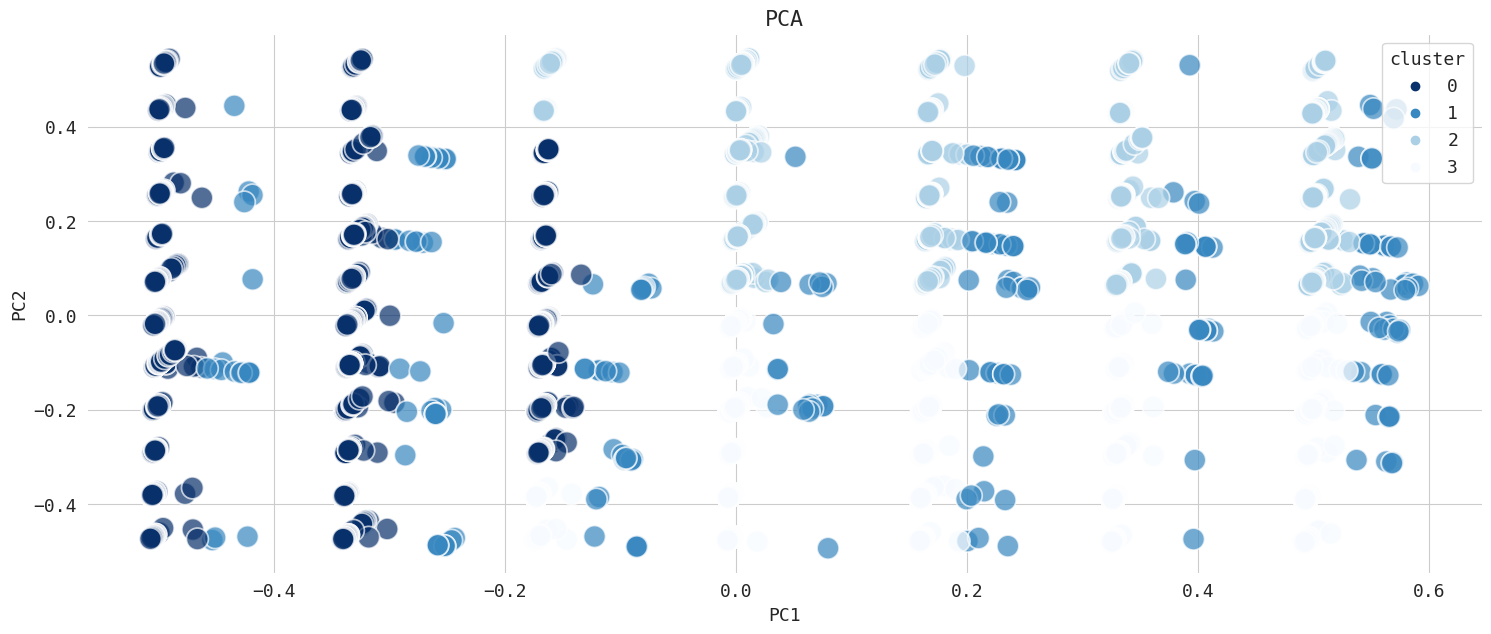

In [ ]:
from sklearn.decomposition import PCA

# the final step is to do a Principal Analysis Compoment study, and plot the clusters accordingly
pca = PCA(random_state=42) # this ensures we always get the same sampling seeds
X_pca = pca.fit_transform(X_scaled)

# we're going to create a dataset based on the 2 PCA analyses we just fitted before
data = feats.assign(
    PC1 = X_pca[:,0], # PC1 will be our first column
    PC2 = X_pca[:,1], # second column, PC2
    cluster=labels # using the same labels as above
)

# plotting
plt.figure()
sns.scatterplot(data=data,
                x="PC1",
                y="PC2",
                s=250, # leaving the size at base value showed points that were too small
                palette="Blues_r",
                hue="cluster", # that's how we see our clusters, using labels from the KMeans model
                alpha=0.7)
plt.title("PCA")
plt.show()

# Next steps

In [ ]:
import datetime as dt
import pandas as pd
import requests
from tabulate import tabulate
from geopy.geocoders import Nominatim

def getCoordinates(city_name):
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(city_name)
    return [location.latitude,location.longitude]

def getForecastWeather(city_name,api_key):
    #coord = getCoordinates(city_name)
    #lat, lon = coord
    lat = 53.3498
    lon = -6.2603
    cnt = 8
    forecast = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}"
    response_forecast = requests.get(forecast).json()
    return response_forecast

def getStruct():
    struct = {
        "timestamp": [],
        "temp": [],
        "humidity": [],
        "report": []
    }
    return struct

def getForecastDataFrame(city_name,api_key):
    struct = getStruct()
    global weather_json
    weather_json = getForecastWeather(city_name,api_key)
    for k,v in weather_json.items():
        if k == "list":
            for val in v:
                struct["timestamp"].append(val["dt_txt"])
                struct["temp"].append(val["main"]["temp"])
                struct["humidity"].append(val["main"]["humidity"])
                struct["report"].append(val["weather"][0]["description"])
    data = pd.DataFrame(struct)
    return data

def getCleanedForecast(city_name,api_key):
    data = getForecastDataFrame(city_name,api_key)
    df = (
    data
    .assign(
        timestamp = lambda x: pd.to_datetime(x["timestamp"]),
        day = lambda x: pd.to_datetime(x["timestamp"]).dt.date,
        temp = lambda x: x["temp"] - 273.15,
        hoursmin = lambda x: pd.to_datetime(x["timestamp"]).dt.strftime('%H:%M')
    )
    .set_index(pd.DatetimeIndex(data["timestamp"].values))
    .sort_values("timestamp", ascending=False)
    )
    df["period"] = df["hoursmin"].apply(lambda x: "am" if x.startswith("0") else "pm")
    return df

forecast = getCleanedForecast("Dublin","c805f74fa906f53d868e70b7076ff3c9")
forecast.head()

,timestamp,temp,humidity,report,day,hoursmin,period
2023-07-30 12:00:00,2023-07-30 12:00:00,18.21,58,overcast clouds,2023-07-30,12:00,pm
2023-07-30 09:00:00,2023-07-30 09:00:00,15.37,76,overcast clouds,2023-07-30,09:00,am
2023-07-30 06:00:00,2023-07-30 06:00:00,13.26,87,broken clouds,2023-07-30,06:00,am
2023-07-30 03:00:00,2023-07-30 03:00:00,13.05,88,broken clouds,2023-07-30,03:00,am
2023-07-30 00:00:00,2023-07-30 00:00:00,12.62,92,few clouds,2023-07-30,00:00,am


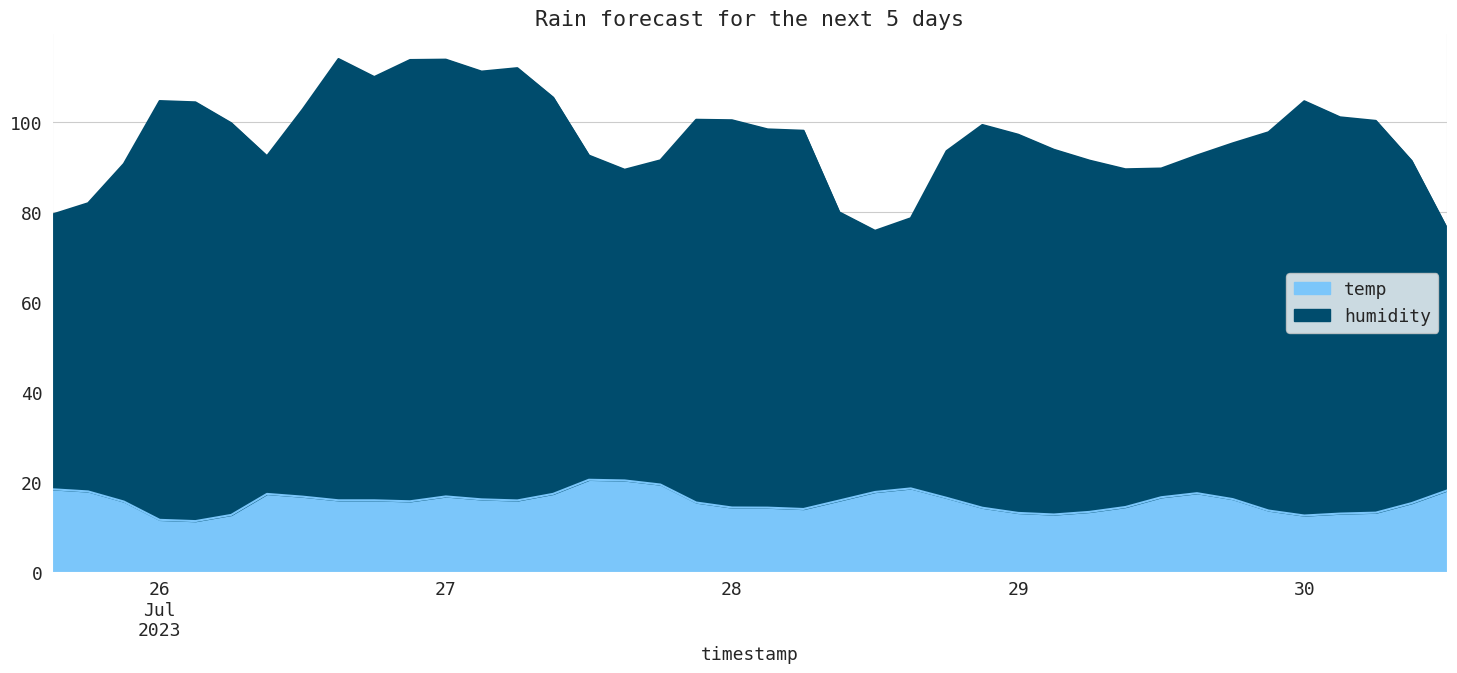

In [ ]:
getAreaPlot(forecast,"timestamp","humidity","Rain forecast for the next 5 days")

In [ ]:
weather_json